## Codice usando i dati presenti nel  [paper(pag 18, paragrafo 4.2)](https://drive.google.com/file/d/1YBFS7FW81_pyuryAb5ISiofgLkT7Gp-P/view?usp=sharing).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from utils import *
import numpy as np 
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler
import dimod
import dwave.inspector
import pickle

In [561]:
mu0 = 0.4
var0 = 0.4

x = np.array([-2.296, -0.216, -0.082, 0.231, 1.127, 1.164, 1.189, 1.236, 1.272, 1.373])

In [586]:
x = np.random.normal(loc=1, scale=1, size=10)

(array([1., 1., 0., 1., 0., 1., 3., 1., 1., 1.]),
 array([-1.78452484, -1.32311533, -0.86170583, -0.40029632,  0.06111318,
         0.52252269,  0.98393219,  1.4453417 ,  1.9067512 ,  2.36816071,
         2.82957021]),
 <BarContainer object of 10 artists>)

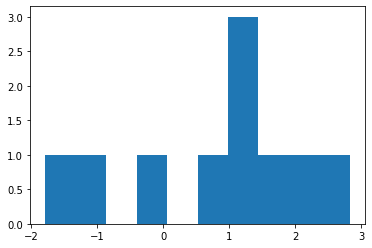

In [587]:
plt.hist(x)

In [588]:
Nodes = [f'a{i}' for i in range(0, 2)] + [f'b{i}' for i in range(0, 2)]

C_G = nx.complete_graph(Nodes)

In [589]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

node_bias = []

for i, node in enumerate(C_G.nodes):
    if node[0] == 'a':
        p = int(node[1:])
        w = -np.sum(2**p * fA(x, mu0, var0) + (2**(2*p - 1) - 2**p*mu0)*fAA(var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_bias.append(w)
        bqm.add_variable(v=node, bias=w)
    else:
        p = int(node[1:])
        w = -np.sum(2**p * fB(x, mu0, var0) + (2**(2*p - 1) - 2**p*var0)*fBB(x, mu0, var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_bias.append(w)
        bqm.add_variable(v=node, bias=w)

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-123.49875348,   83.87255844,  291.24387036,  498.61518229,
         705.98649421,  913.35780614, 1120.72911806, 1328.10042998,
        1535.47174191, 1742.84305383, 1950.21436575]),
 <BarContainer object of 10 artists>)

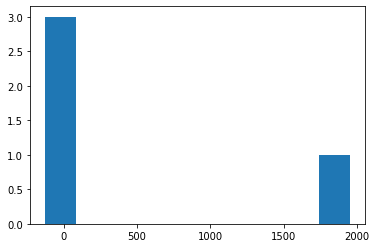

In [590]:
plt.hist(node_bias)

In [591]:
A = []
B = []
AB = []

link_A, link_B, link_AB = 0, 0, 0
eps_A = 0
eps_B = 0
eps_AB = 10000

for edge in C_G.edges:
    node1, node2 = edge
    if node1[0] == node2[0] == 'a':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -2**(pi+pj)*fAA(var0)
        
        #w = np.sqrt(w)
        if w > eps_A:
            link_A += 1
            A.append(w)
            bqm.add_interaction(node1, node2, w)
            
    elif node1[0] == node2[0] == 'b':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fBB(x, mu0, var0))
        
        #w = np.sqrt(w)
        if w > eps_B:
            link_B += 1
            B.append(w)
            bqm.add_interaction(node1, node2, w)
            
    else:
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fAB(x, mu0, var0))
        
        #w = np.sqrt(w)
        if w < eps_AB:    
            link_AB += 1
            AB.append(w)
            bqm.add_interaction(node1, node2, w)

In [592]:
np.max(A + B +AB)

4394.42374543676

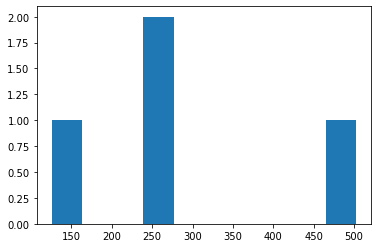

In [593]:
plt.hist(AB, bins=10);

In [594]:
link_A, link_B, link_AB, link_A+link_B+link_AB

(1, 1, 4, 6)

In [595]:
np.sum(-(x-mu0)**2/(var0)**2)

-117.18463321164694

In [624]:
sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=5000, chain_strength=0) #

In [625]:
sampleset.variables

Variables(['a0', 'a1', 'b0', 'b1'])

In [626]:
sampleset.record

rec.array([([0, 0, 1, 0], -123.49875348, 1371, 0.),
           ([1, 1, 0, 0],  -87.18008781,  655, 0.),
           ([1, 0, 0, 0],  -54.06002927,  526, 0.),
           ([1, 0, 1, 0],  -51.91288844,  721, 0.),
           ([0, 1, 0, 0],  -45.62005854,  646, 0.),
           ([0, 0, 0, 0],    0.        ,  470, 0.),
           ([0, 1, 1, 0],   82.1729766 ,  416, 0.),
           ([1, 1, 1, 0],  166.25884165,  194, 0.),
           ([0, 0, 0, 1], 1950.21436575,    1, 0.)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i4'), ('chain_break_fraction', '<f8')])

In [627]:
'''lowest_state = sampleset.lowest().record[0][0]
mu, var = 0, 0

for i, sol in enumerate(lowest_state):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
mu, var'''

"lowest_state = sampleset.lowest().record[0][0]\nmu, var = 0, 0\n\nfor i, sol in enumerate(lowest_state):\n        p = int(sampleset.variables[i][1:])\n        if sampleset.variables[i][0] == 'a':\n            mu = mu + 2**(p) * sol\n        else:\n            var = var + 2**(p) * sol\n            \nmu, var"

In [660]:
theta = []
phi = []
energy = []

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    energy += [rec[1]] * freq
    freq = rec[2]
    mu = 0
    var = 0
    for i, sol in enumerate(states):
        #p = int(sampleset.variables[i][1:])
        p = int(Nodes[-i][1:])
        if Nodes[-i][0] == 'a':
        #if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
    theta += [mu] * freq
    phi += [var] * freq

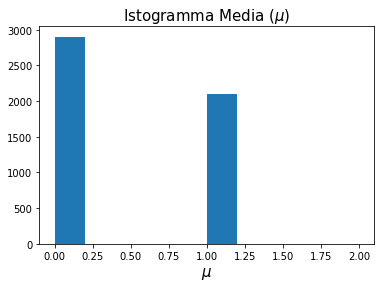

In [674]:
plt.hist(theta, bins='auto');
plt.xlabel('$\mu$', fontdict={'fontsize': 15})
plt.title('Istogramma Media ($\mu$)', fontdict={'fontsize':15})
plt.savefig('media.png')

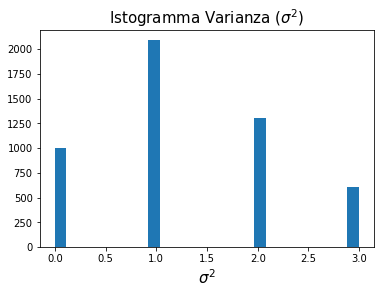

In [662]:
plt.hist(phi, bins='auto')
plt.xlabel('$\sigma^2$', fontdict={'fontsize': 15})
plt.title('Istogramma Varianza ($\sigma^2$)', fontdict={'fontsize':15})
plt.savefig('varianza.png')

Text(0, 0.5, 'Varianza')

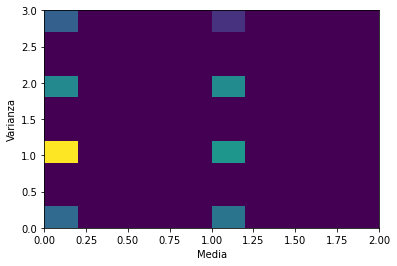

In [663]:
plt.hist2d(theta, phi);
plt.xlabel('Media')
plt.ylabel('Varianza')

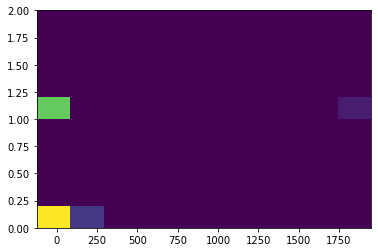

In [672]:
plt.hist2d(energy, theta);

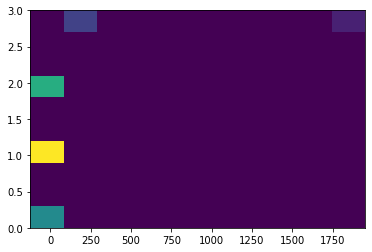

In [671]:
plt.hist2d(energy, phi);

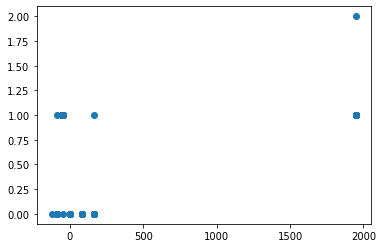

In [667]:
plt.scatter(energy, theta)

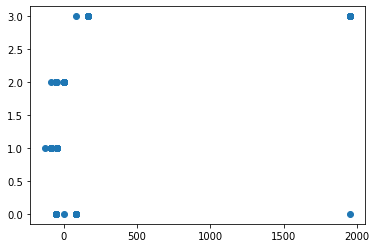

In [668]:
plt.scatter(energy, phi)

In [669]:
dwave.inspector.show(sampleset)

'http://127.0.0.1:18000/?problemId=c51a147b-2a39-48e9-b442-e86ef9ab9508'